In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from plotting_fxns import *

In [20]:
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv',index_col=0)
temp_df = temp_df.set_index(pd.to_datetime(temp_df.index)) # + pd.Timedelta(hours=8))
h0 = 3.5 - np.array([.1,.4,.8,1.2,1.6,2,2.4,2.8,3.2,3.49])
for i,column in enumerate(temp_df.columns):
    temp_df = temp_df.rename(columns={column:str(int(round(h0[i]*100,0)))})
temp_df = temp_df.rename(columns={'1':'0'})
temp_df.to_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv')

In [23]:
glacier = 'Gulkana'
id = '1'
date = str(pd.Timestamp.today()).replace('-','_')[0:10]
# date=  '2024_05_28'
data_fp = f'/home/claire/research/Output/EB/{glacier}_{date}_#.nc'
# data_fp = f'/home/claire/research/Output/EB/Mend-2_best.nc'
ds,startdate,enddate = getds(data_fp.replace('#',id))
# base_fp = f'/home/claire/research/Output/EB/Gulkana_2024_05_07_3.nc'
# base_ds,_,_ = getds(base_fp)
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df.index = pd.to_datetime(stake_df['Date'])
temp_df = pd.read_csv('~/research/MB_data/Gulkana/field_data/iButton_2023_all.csv',index_col=0)
temp_df = temp_df.set_index(pd.to_datetime(temp_df.index) - pd.Timedelta(hours=8))

In [26]:
data_fp = '/home/claire/research/Data/Nagorski/bcdust.csv'
df = pd.read_csv(data_fp,index_col=0) #.iloc[0]
df_new = pd.DataFrame(np.zeros(8),
    index=np.arange(15,240,30)/100)
x = 'BC'
for site in df.index:
    for x in ['BC','dust']:
        if x in ['dust']:
            dd = 50
            idx = np.arange(25,205,50)/100
        elif x in ['BC']:
            dd = 30
            idx = np.arange(15,240,dd)/100
        df_new = pd.DataFrame(np.zeros(len(idx)),
            index=idx)
        df_new[x] = np.ones(len(idx))
        for d in df_new.index:
            b = int(d*100+dd/2)
            t = int(d*100-dd/2)
            factor = 1e6 if x == 'BC' else 1e3
            data = df[f'{x}_May_{t}_{b}'].loc[site] / factor
            df_new.loc[d,x] = data
        df_new = df_new.drop(columns=[0])
        df_new = df_new.interpolate()
        df_new.to_csv(f'/home/claire/research/Data/Nagorski/May_{site}_{x}.csv')
print(df_new)

        dust
0.25  0.0010
0.75  0.0016
1.25  0.0027
1.75  0.0015


In [27]:
bc_df = pd.read_csv('/home/claire/research/Data/Nagorski/bcdust.csv',index_col=0)
bc_df = bc_df.iloc[:-1]

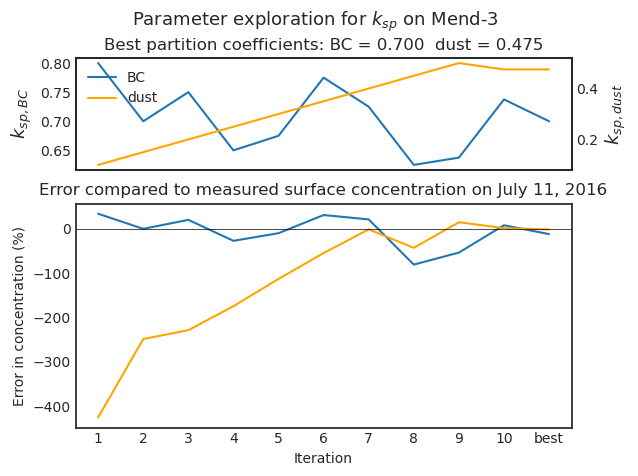

In [35]:
site = 'Mend-3'
iters = np.arange(1,11)

# select measurements
BC_surf = bc_df.loc[site,'Surface_BC_July']
dust_surf = bc_df.loc[site,'Surface_dust_July']

# create figure
fig,axes = plt.subplots(2,sharex=True,height_ratios=[1,2])
fig.suptitle('Parameter exploration for $k_{sp}$ on '+site,fontsize=13)

#initialize loop
iters = np.append(iters,'best')
result = {'BC':[],'dust':[],
          'ksp_BC':[],'ksp_dust':[]}
for i in iters:
    # open data
    data_fp = f'/home/claire/research/Output/EB/{site}_iter{i}.nc'
    if i == 'best':
        data_fp = f'/home/claire/research/Output/EB/{site}_{i}.nc'
    ds = xr.open_dataset(data_fp)

    # get final surface concentration
    BC_surf_final = ds.layerBC.isel(bin=0,layer=0,time=-1).values
    dust_surf_final = ds.layerdust.isel(bin=0,layer=0,time=-1).values  
    
    # store results
    result['BC'].append((BC_surf-BC_surf_final)/BC_surf*100)
    result['dust'].append((dust_surf-dust_surf_final)/dust_surf*100)
    result['ksp_BC'].append(ds.attrs['ksp_BC'])
    result['ksp_dust'].append(ds.attrs['ksp_dust'])
# plot ksp
axes[0].plot(iters,np.array(result['ksp_BC']).astype(float),label='BC')
axes[0].plot(np.nan,np.nan,label='dust',color='orange')
axes[0].legend()
axes[0].set_ylabel('$k_{sp, BC}$',fontsize=13)
twin = axes[0].twinx()
twin.plot(iters,np.array(result['ksp_dust']).astype(float),label='dust',color='orange')
twin.set_ylabel('$k_{sp, dust}$',fontsize=13)
ksp_BC = np.array(result['ksp_BC'])[-1]
ksp_dust = np.array(result['ksp_dust'])[-1]
axes[0].set_title(f'Best partition coefficients: BC = {ksp_BC[:5]}  dust = {ksp_dust[:5]}')

# plot results
axes[1].plot(iters,result['BC'])
axes[1].plot(iters,result['dust'],color='orange')
axes[1].axhline(0,color='black',linewidth=0.5)
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Error in concentration (%)')
axes[1].set_title('Error compared to measured surface concentration on July 11, 2016')

# store the figure
plt.savefig(f'/home/claire/research/Output/calibration/{site}_ksp.png')
plt.show()

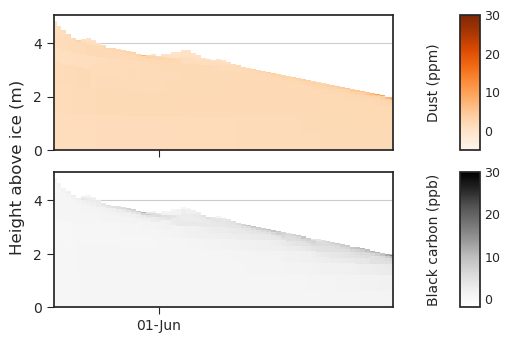

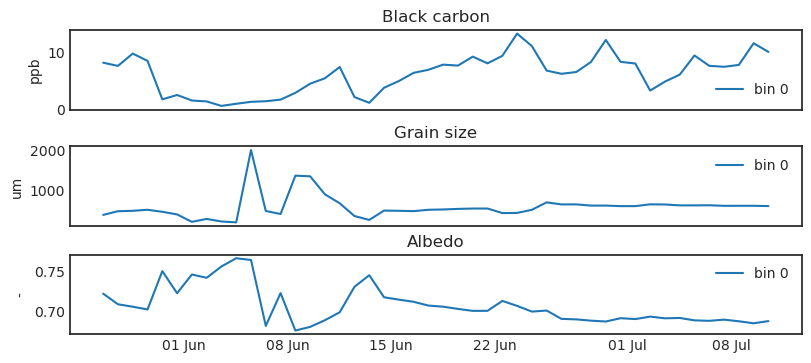

In [22]:
# plot_avg_layers(ds,0)
site = 'Mend-3'
ds,startdate,enddate = getds(f'/home/claire/research/Output/EB/{site}_best.nc')
# visualize_layers(ds,0,pd.date_range(startdate,enddate,freq='d'),['layerdust','layerBC'],t='') #,plot_ice=True,ylim=(0,165))
plot_single_layer(ds,0,['layerBC','layergrainsize','albedo'],['2016-05-26 12:30','2016-07-10 12:30'],res='d')

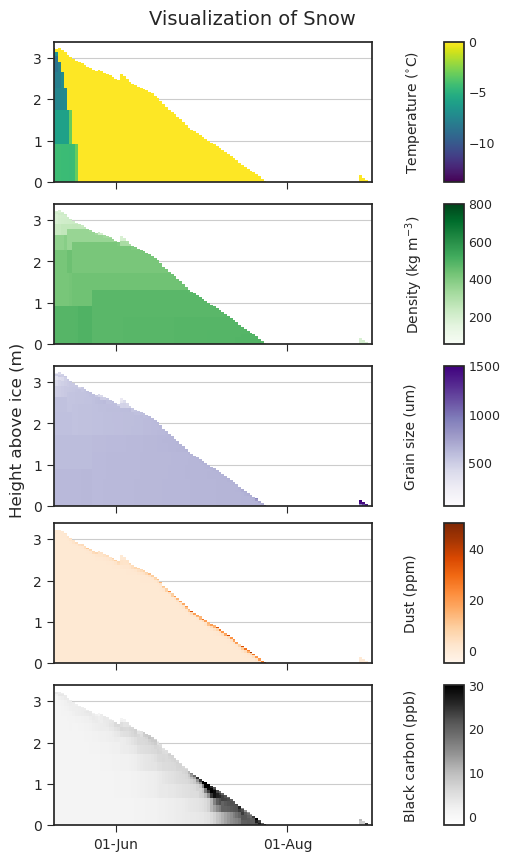

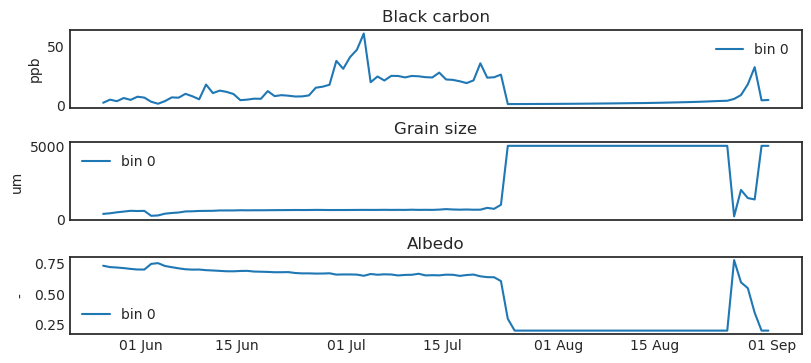

In [107]:
visualize_layers(ds,0,pd.date_range(startdate,enddate,freq='d'),['layertemp','layerdensity','layergrainsize','layerdust','layerBC']) #,plot_ice=True,ylim=(0,165))
plot_single_layer(ds,0,['layerBC','layergrainsize','albedo'],['2004-05-26 12:30',enddate],res='d')

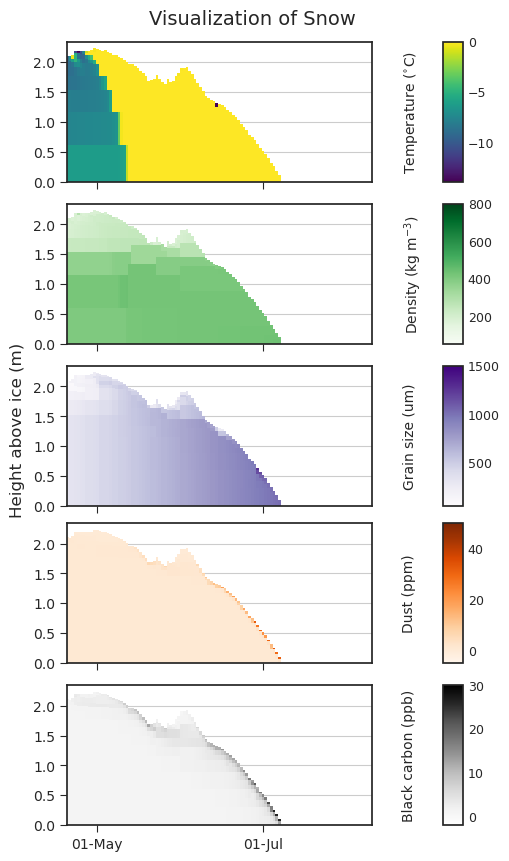

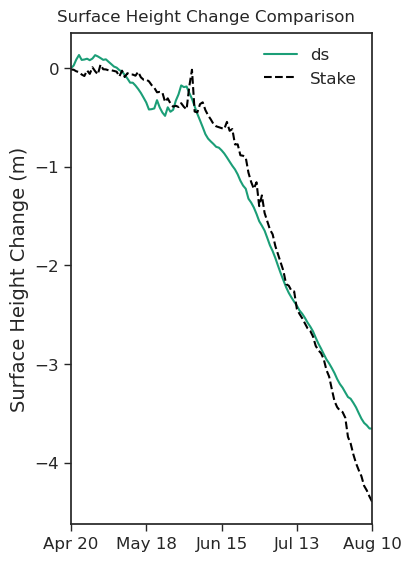

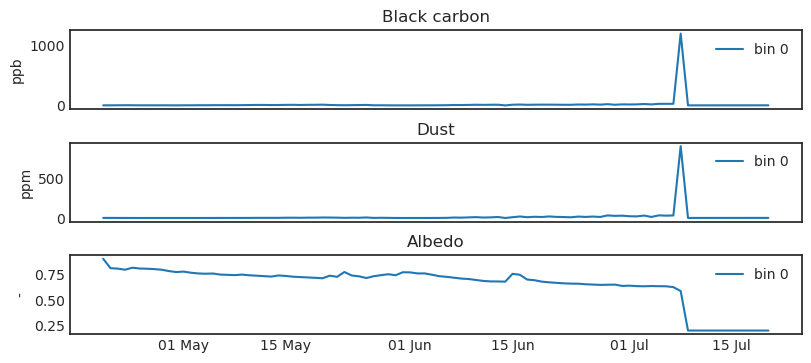

In [44]:
# 2024_07_15_18
ds,startdate,enddate = getds(f'/home/claire/research/Output/EB/{glacier}_2024_07_15_25.nc')
visualize_layers(ds,0,pd.date_range(startdate,enddate,freq='d'),['layertemp','layerdensity','layergrainsize','layerdust','layerBC'])
# visualize_layers(ds,0,pd.date_range('2023-05-10 00:30','2023-05-20 00:30',freq='2h'),['layergrainsize','layerdensity','layerwater'],ylim=(3.5,4))
dh_vs_stake(stake_df,[ds],[startdate,enddate],labels=['ds'])
plot_single_layer(ds,0,['layerBC','layerdust','albedo'],[startdate,'2023-07-20 00:30'],res='d')

1467.3745454545453
1290.8211764705882


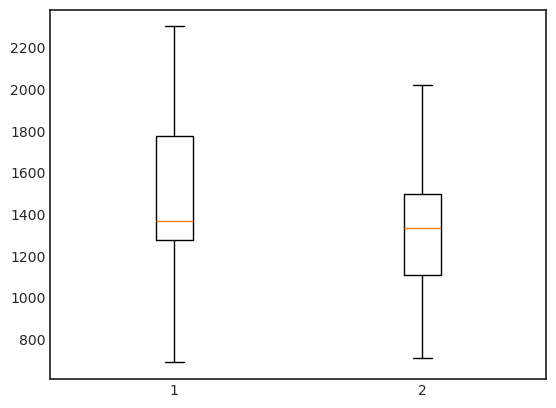

In [60]:
wolverine = pd.read_csv('/home/claire/research/climate_data/AWS/Benchmark/wolverine/LVL2/wolverine990_daily_LVL2.csv')
gulkana = pd.read_csv('/home/claire/research/climate_data/AWS/Gulkana/LVL2/gulkana1480_daily_LVL2.csv')
wolverine.index = pd.to_datetime(wolverine['Date'])
gulkana.index = pd.to_datetime(gulkana['Date'])
# print(wolverine['Date'].iloc[0],wolverine['Date'].iloc[-1])
# print(gulkana['Date'].iloc[0],gulkana['Date'].iloc[-1])
wolverine['Precip_Weighing_Incremental'] = wolverine['Precip_Weighing_Incremental'].fillna(wolverine['Precip_Stage_Incremental']*2.28) #, inplace=True)
gulkana['Precip_Weighing_Incremental'] = gulkana['Precip_Weighing_Incremental'].fillna(gulkana['Precip_Stage_Incremental']*1.48) #, inplace=True)
dates = np.concatenate([pd.date_range('2000-01-01','2015-12-31'),
                       pd.date_range('2017-01-01','2018-12-31')])
wolverine = wolverine.loc[dates]
gulkana = gulkana.loc[pd.date_range('2000-01-01','2018-12-31')]
wolverine = wolverine['Precip_Weighing_Incremental'].resample('YS').sum().to_numpy()
gulkana = gulkana['Precip_Weighing_Incremental'].resample('YS').sum().to_numpy()
print(np.mean(wolverine[wolverine != 0.]))
print(np.mean(gulkana[gulkana != 0.]))
plt.boxplot([wolverine[wolverine != 0.],gulkana[gulkana != 0.]])
plt.show()

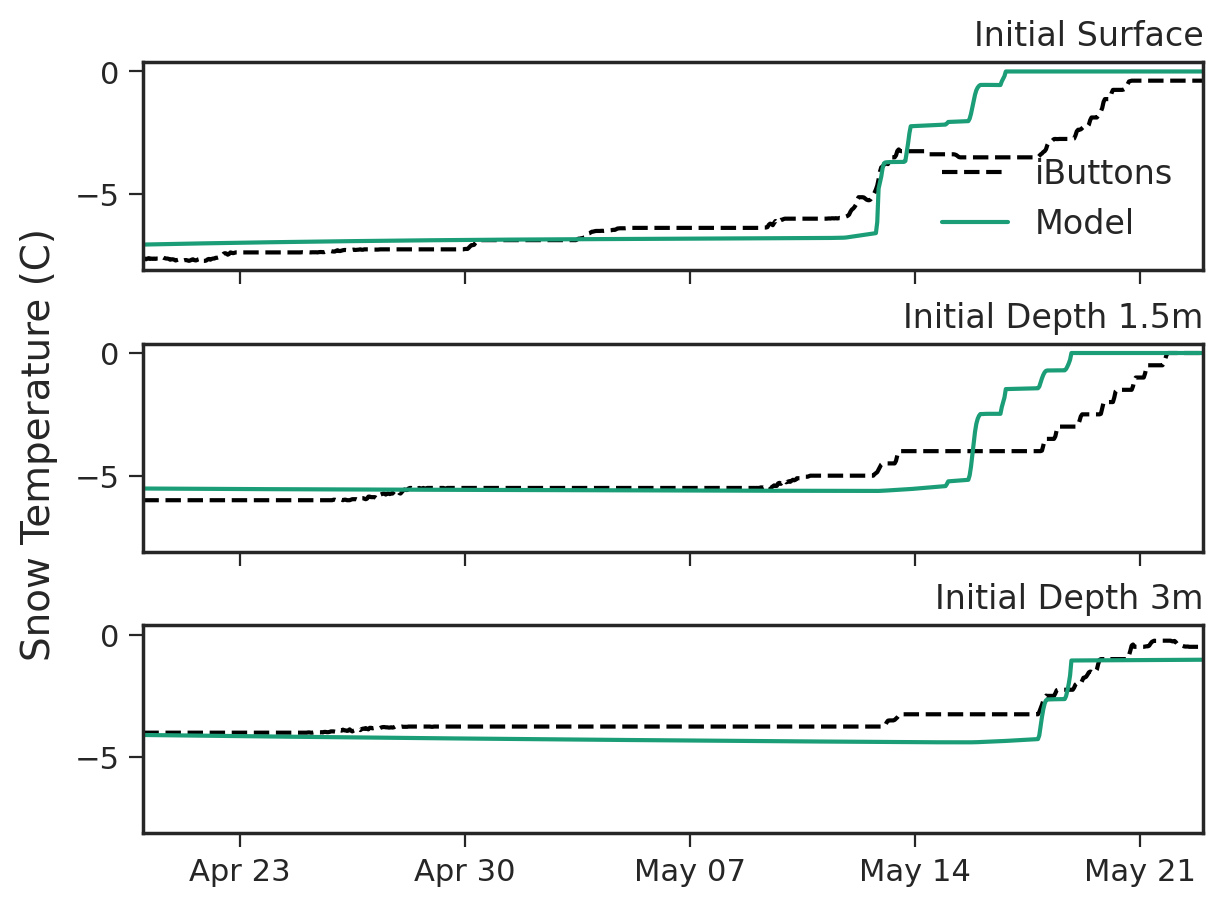

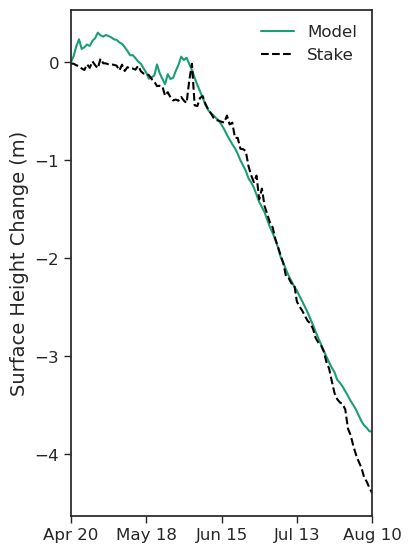

In [5]:
# dsboone,startdate,enddate = getds(data_fp.replace('#','0'))
# dsherron,_,_ = getds(data_fp.replace('#','1'))
dsboone,startdate,enddate = getds(data_fp.replace('#','31'))

temp_vs_iButton([ds],temp_df,[startdate,enddate],0,plot_heights=[2.2,1.5,.5],ax_titles=['Initial Surface','Initial Depth 1.5m','Initial Depth 3m'],t='')
plt.savefig('/home/claire/research/snowtemps_7_15.png',dpi=200)
dh_vs_stake(stake_df,[ds],[startdate,enddate],t='') # labels=['Anderson','Herron-Langway']
plt.savefig('/home/claire/research/dh_compare_7_15.png',dpi=200)

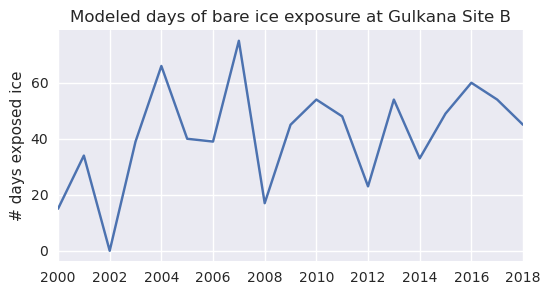

In [14]:
store = []
fig,ax = plt.subplots(figsize=(6,3))
for year in range(2000,2019):
    start = pd.to_datetime(str(year)+'-06-15 00:30')
    end = pd.to_datetime(str(year)+'-10-30 00:30')
    dates = pd.date_range(start,end,freq='h')
    density = ds.layerdensity.sel(time=dates,bin=0).resample(time='d').mean()
    ice_days = density.sel(layer=0).values > 700
    store.append(sum(ice_days))
ax.plot(np.arange(2000,2019),store)
ax.set_ylabel('# days exposed ice')
ax.set_xticks(np.arange(2000,2019,2).astype(int))
ax.set_xlim(2000,2018)
ax.set_title('Modeled days of bare ice exposure at Gulkana Site B')
plt.show()

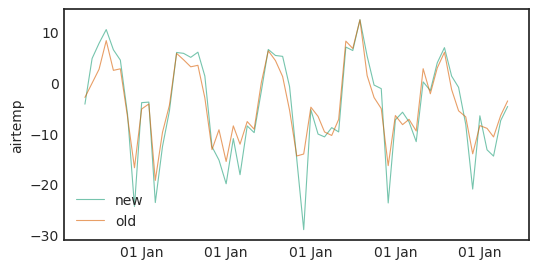

In [78]:
ds2,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_05_28_1.nc')
compare_runs([ds,ds2],['2010-05-01 00:30','2015-06-01 00:30'],['new','old'],'airtemp','MS')

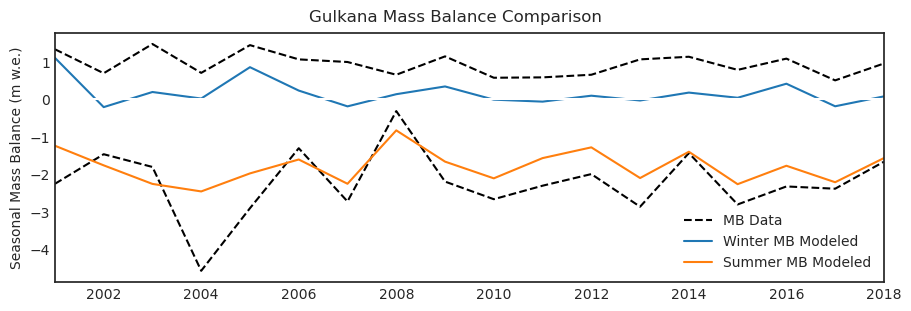

In [30]:
# ds,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_07_15_21.nc')
# ds,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_05_28_1.nc')
mb_fp = '/home/claire/research/MB_data/Gulkana/Input_Gulkana_Glaciological_Data.csv'
ds_list = [ds]
years = np.arange(2001,2019)
site = 'B'
mb_df = pd.read_csv(mb_fp)
# start func
fig,ax = plt.subplots(figsize=(9,3),sharex=True,layout='constrained')
mb_df = mb_df.loc[mb_df['site_name'] == site]
mb_df.index = mb_df['Year']

# plot mass balance data
winter_mb_data = mb_df['bw'].loc[mb_df['Year'].isin(years)]
summer_mb_data = mb_df['ba'].loc[mb_df['Year'].isin(years)] - mb_df['bw'].loc[mb_df['Year'].isin(years)]
ax.plot(years,winter_mb_data,label='MB Data',color='black',linestyle='--')
ax.plot(years,summer_mb_data,color='black',linestyle='--')

mb_mod = {'bw':[],'bs':[]}
for ds in ds_list:
    for year in years:
        # spring_date = mb_df['spring_date'].loc[year]
        # fall_date = mb_df['fall_date'].loc[year]
        # next_spring_date = mb_df
        spring_date = str(year)+'-04-20 00:00'
        fall_date = str(year)+'-08-20 00:00'
        next_spring_date = str(year)+'-04-20 00:00'
        last_fall_date = str(year-1)+'-08-20 00:00'
        melt_dates = pd.date_range(spring_date,fall_date,freq='h')
        acc_dates = pd.date_range(last_fall_date,spring_date,freq='h')
        if pd.to_datetime(ds.time.values[0]).minute == 30:
            melt_dates = melt_dates + pd.Timedelta(minutes=30)
            acc_dates = acc_dates + pd.Timedelta(minutes=30)
        # sum mass balance
        wds = ds.sel(time=acc_dates).sum()
        sds = ds.sel(time=melt_dates).sum()
        winter_mb = wds.accum + wds.refreeze - wds.melt
        summer_mb = sds.accum + sds.refreeze - sds.melt
        mb_mod['bw'].append(winter_mb.to_numpy())
        mb_mod['bs'].append(summer_mb.to_numpy())
    ax.plot(years,mb_mod['bw'],label='Winter MB Modeled')
    ax.plot(years,mb_mod['bs'],label='Summer MB Modeled')
ax.legend()
ax.axhline(0,color='white')
ax.set_ylabel('Seasonal Mass Balance (m w.e.)')
ax.set_xlim(2001,2018)
ax.set_xticks(np.arange(2002,2020,2))
fig.suptitle('Gulkana Mass Balance Comparison')
# plt.show()
plt.savefig('/home/claire/research/20yrfig.png',dpi=200)

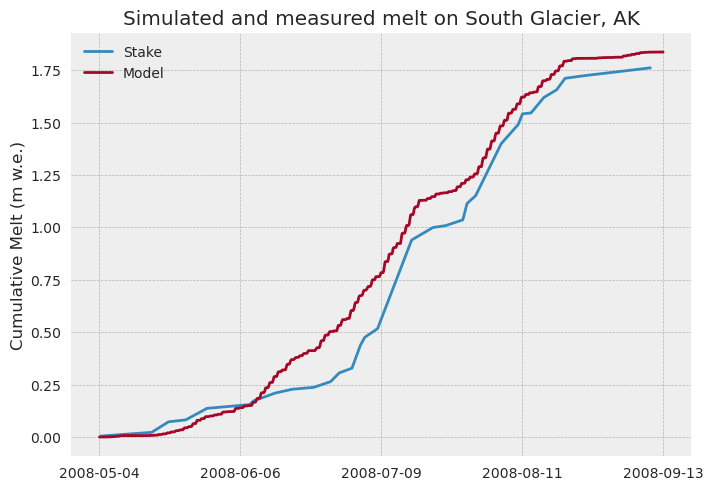

In [65]:
ds,startdate,enddate = getds(data_fp.replace('#','12'))
df = pd.read_csv('/home/claire/research/MB_data/South/stakes.csv',index_col=0)
df.index = pd.to_datetime(df.index)
# start = pd.to_datetime('2008-07-22 00:30')
# df = df.loc[start:] - 1.02
# ds = ds.sel(time=pd.date_range(start,enddate,freq='h'))
plt.plot(df.index,df['Melt'],label='Stake')
# ds = ds.resample(time='d').sum()
plt.plot(ds.coords['time'],ds['melt'].cumsum(),label='Model')

# plt.plot(ds_MERRA.coords['time'],ds_MERRA['melt'].cumsum(),label='Model (MERRA)')
# plt.plot(ds_AWS.coords['time'],ds_AWS['melt'].cumsum(),label='Model (AWS)')
plt.ylabel('Cumulative Melt (m w.e.)')
plt.xticks(pd.date_range(startdate,enddate,periods=5))
plt.title('Simulated and measured melt on South Glacier, AK')
plt.legend()

This notebook is intended to make plotting of the PyGEM-EB output straightforward for fast diagnostics after a model run. Most functions just need the information for the model run in the cell below. 

Specify the plotting style to use and the figure name to save the plot.

Run the following cells to plot the data. For information on any of the plotting functions, run 'help(name_of_function)'. Available functions are:
- simple_plot
- plot_AWS
- plot_stake_data
- compare_runs
- stacked_eb_barplot

In [9]:
labels = []
params = {
    'kp':[0.5,0.8],
    'albedo_ice':[0.1,0.3],
    'k_ice':[1,4],
    'ksp_BC':[0.01,0.8]
}
for kp in params['kp']:
    for aice in params['albedo_ice']:
        for ksp in params['ksp_BC']:
            for k_ice in params['k_ice']:
                labels.append(f'kp: {kp}, a_ice: {aice}, ksp_BC: {ksp}, k_ice: {k_ice}')
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df.index = pd.to_datetime(stake_df['Date'])

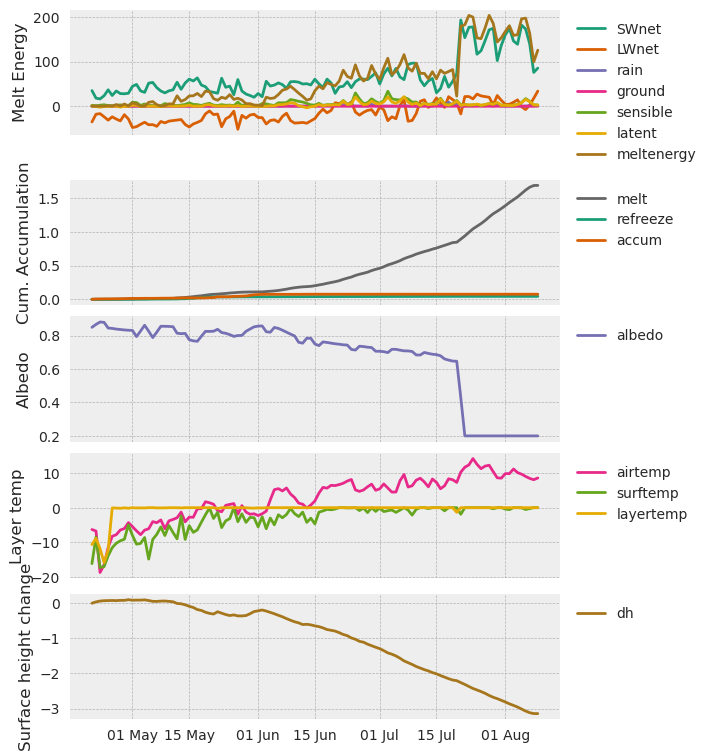

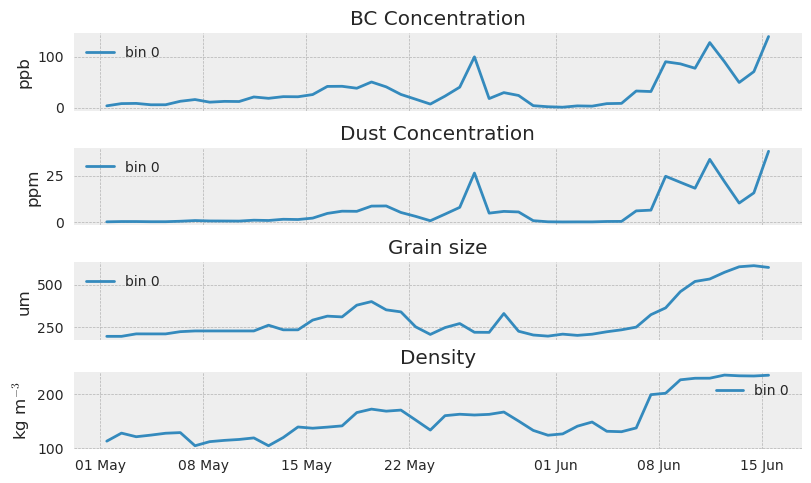

In [35]:
# from plotting_fxns import *
ds,startdate,enddate = getds('~/research/Output/EB/Gulkana_2024_03_13_BASE.nc') # 3_08_1
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_ALL.csv')
stake_df = stake_df.set_index(pd.to_datetime(stake_df['Date']))
# plot_stake_dh(stake_df,[ds],[startdate,enddate],['ds'])
dates = pd.date_range(startdate,enddate,freq='3d')
all = [['SWnet','LWnet','rain','ground','sensible','latent','meltenergy'],
       ['melt','refreeze','accum'],
       ['albedo'],
       ['airtemp','surftemp','layertemp'],
       ['dh']]
simple_plot(ds,0,[startdate,enddate],all)
plot_single_layer(ds,0,['layerBC','layerdust','layergrainsize','layerdensity'],['2023-05-01 10:30','2023-06-15 10:30'],resample=False,res='d')
# for var in ['layerBC','layertemp','layerdensity']: # 
#     # for bin in range(3):
#     for bin in [0]:
#         visualize_layers(ds,bin,dates,var,plot_firn=False)

In [19]:
switches = ['000','010','001','110','020','021','120','121']
fp = '/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_02_02_'
ds_list = []
label_list = []
for switch in switches:
    ds,_,_ = getds(fp+switch+'.nc')
    ds_list.append(ds)
    label_list.append(switch)

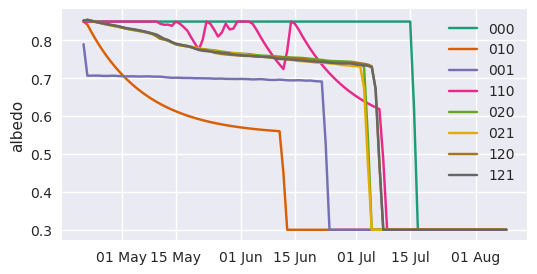

In [20]:
compare_runs(ds_list,[startdate,enddate],label_list,'albedo')

In [15]:
param_options = {
          'lapserate':{'options':[-0.003,-0.01],'value':-0.0065,'units':'K m-1'},
          'k_ice':{'options':[1.5,3],'value':2.33,'units':'W K-1 m-1'},
          'precgrad':{'options':[5e-6,5e-4],'value':0.0001,'units':''},
          'kp':{'options':[0.5,2],'value':1,'units':''},
          'albedo_ice':{'options':[0.2,0.4],'value':0.3,'units':''},
          'roughness_ice':{'options':[0.5,3],'value':1.7,'units':'mm'},
          'ksp_BC':{'options':[0.01,0.8],'value':0.1,'units':'kg kg-1'},
          'ksp_dust':{'options':[0.001,0.08],'value':0.015,'units':'kg kg-1'},
          'dz_toplayer':{'options':[0.01,0.05],'value':0.03,'units':'m'},
          'layer_growth':{'options':[0.6,0.9],'value':0.6,'units':''},
          'roughness_aging_rate':{'options':[0.04,0.08],'value':0.06267,'units':'mm d-1'},
          'dry_metamorphism_rate':{'options':[1e-5,1e-4],'value':3.5e-5,'units':'um s-1'}
          }
filename = '/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_03_13_VAR_VALUE.nc'

ds_dict = {}
for key in list(param_options.keys()):
    for value in param_options[key]['options']:
        fn = filename.replace('VAR',key).replace('VALUE',str(value))
        ds,startdate,enddate = getds(fn)
        ds_dict[key+'='+str(value)] = ds

# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
# ds_dict['LAPbins=yes'] = ds
# ds,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds_dict['LAPbins=no'] = ds

Date
2023-04-18    217.98
2023-04-19    217.63
2023-04-20    217.11
2023-04-21    215.82
2023-04-22    215.11
               ...  
2023-08-19      0.00
2023-08-20      0.00
2023-08-21      0.00
2023-08-22      0.00
2023-08-23      0.00
Name: snow_depth, Length: 128, dtype: float64


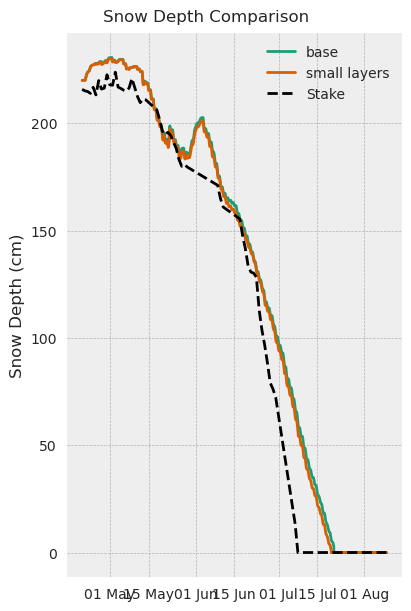

In [25]:
ds_base,_,_ = getds('~/research/Output/EB/Gulkana_2024_03_13_BASE.nc')
ds_small,_,_ = getds('~/research/Output/EB/Gulkana_2024_03_13_2.nc')
plot_stake_dh(stake_df,[ds_base,ds_small],[startdate,enddate],['base','small layers'])
plot_stake_snowdepth(stake_df,[ds_base,ds_small],[startdate,enddate],['base','small layers'])

/home/claire/research/PyGEM-EB/pygem_eb/processing/plotting_fxns.py:436: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


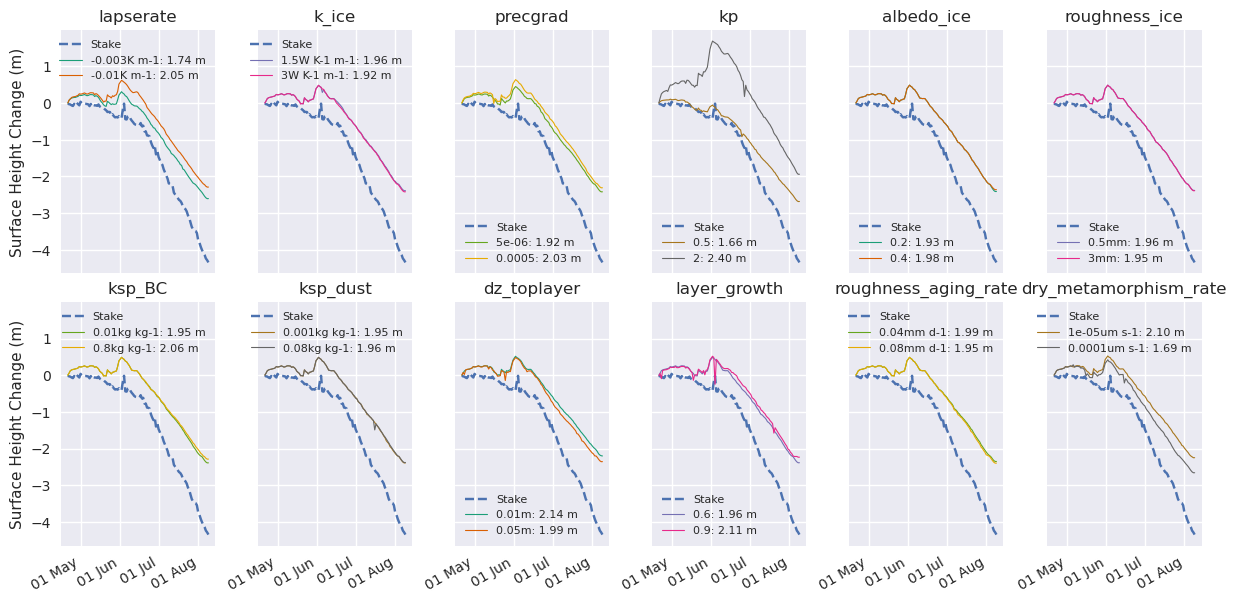

In [19]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
stake_df = pd.read_csv('~/research/MB_data/Stakes/gulkanaAB23_GNSSIR.csv')
stake_df = stake_df.set_index(pd.to_datetime(stake_df['Date']))
units = [param_options[label.split('=')[0]]['units'] for label in labels]
panel_dh_compare(ds_list,[startdate,enddate],labels,units,stake_df)

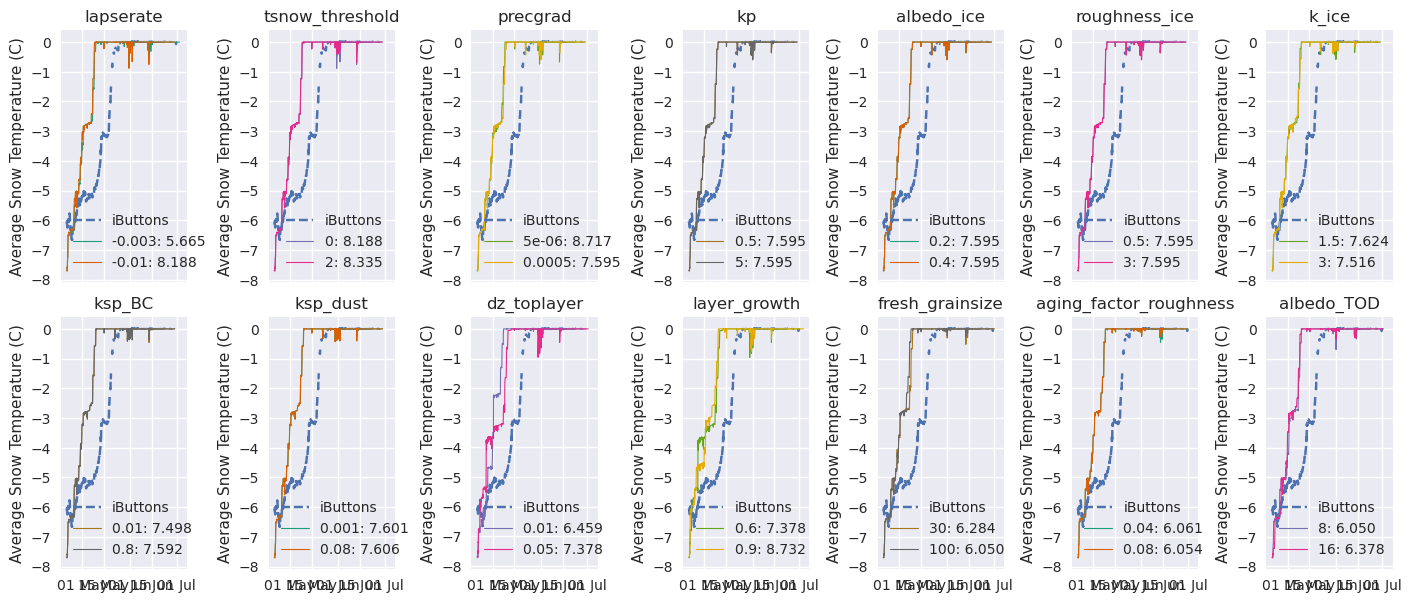

In [50]:
ds_list = list(ds_dict.values())
labels = list(ds_dict.keys())
panel_temp_compare(ds_list,[startdate,enddate],labels,temp_df)

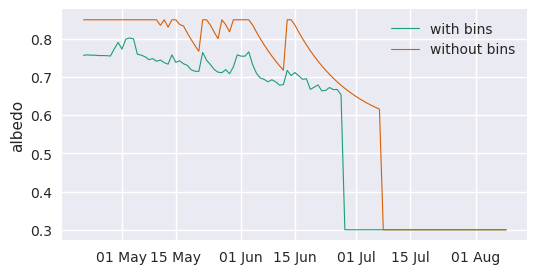

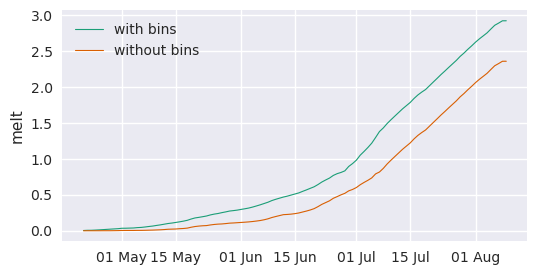

In [117]:
ds_base,startdate,enddate = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_0.nc')
ds_nolapbins,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_22_noLAPbins.nc')
# ds__,_,_ = getds('/home/claire/research/PyGEM-EB/../Output/EB/Gulkana_2024_01_11_noLAPbins1.nc')
# ds_list = list(ds_dict.values())[0:5]
# labels = list(ds_dict.keys())[0:5]
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'albedo')
compare_runs([ds_base,ds_nolapbins],[startdate,enddate],['with bins','without bins'],'melt')

0 1
0 1


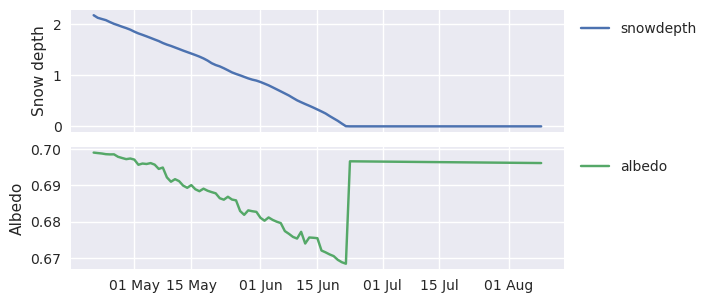

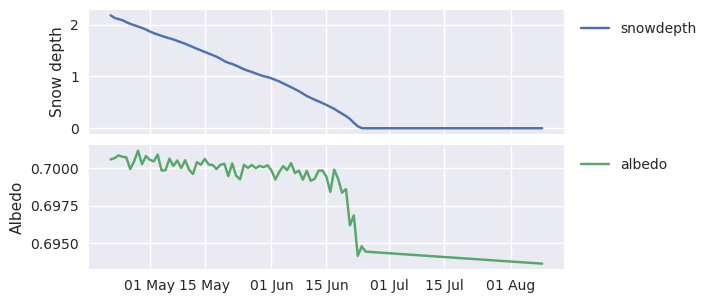

In [25]:
simple_plot(ds,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
simple_plot(ds3,0,[startdate,enddate],
            [['snowdepth'],['albedo']],
            t = '',
            skinny = True,
            new_y='accum',
            save_fig=False)
print(ds.attrs['switch_melt'],ds.attrs['switch_LAPs'])
print(ds3.attrs['switch_melt'],ds3.attrs['switch_LAPs'])

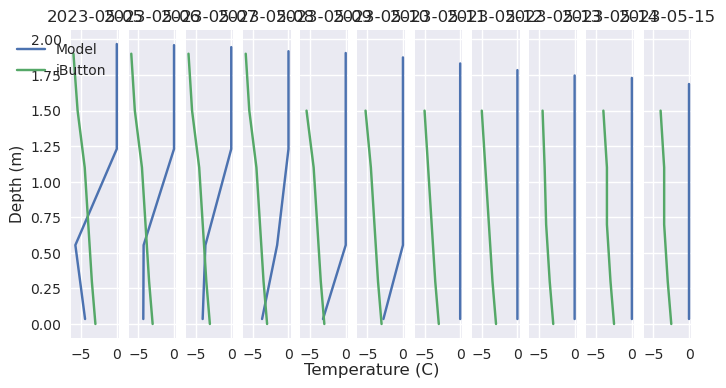

In [29]:
plot_iButtons(list(ds_list)[16],0,pd.date_range('05-05-2023 00:00','05-15-2023 00:00',freq='d'))